In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [5]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the input shape
input_shape = (784,)

# Define the encoder part of the autoencoder
input_layer = Input(shape=input_shape)
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

# Define the decoder part of the autoencoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Define the MLP
mlp = Dense(64, activation='relu')(encoded)
mlp = Dense(10, activation='softmax')(mlp)

# Combine the autoencoder and MLP into a single model
model = Model(inputs=input_layer, outputs=[decoded, mlp])

# Define the combined loss function with a trainable weight
alpha = tf.Variable(0.5, dtype=tf.float32)
def combined_loss(y_true, y_pred):
    # Reconstruction loss of the autoencoder
    recon_loss = keras.losses.mean_squared_error(y_true[0], y_pred[0])
    
    # Classification loss of the MLP
    class_loss = keras.losses.categorical_crossentropy(y_true[1], y_pred[1])
    
    # Trainable weight to balance the two losses
    global alpha
    
    # Combine the two losses with the trainable weight
    combined_loss = alpha * recon_loss + (1 - alpha) * class_loss
    
    return combined_loss

# Define a callback to predict the output of the MLP on a validation set
class PredictMLPCallback(Callback):
    def __init__(self, x_test):
        super(PredictMLPCallback, self).__init__()
        self.x_val = x_test
        self.predictions = []

    def on_epoch_end(self, epoch, logs=None):
        mlp_output = self.model.predict(self.x_val)[1]
        self.predictions.append(mlp_output)

learn_rate = 1e-3
adam = Adam(learning_rate=learn_rate)
        
# Compile the model with the combined loss function
model.compile(optimizer=adam, loss=combined_loss)

# Create instance of PredictMLPCallback
predict_mlp_callback = PredictMLPCallback(x_test)

# Train the model
model.fit(x_train, [x_train, y_train], epochs=10, batch_size=128, callbacks=[predict_mlp_callback])

# Evaluate the model
model.evaluate(x_test, [x_test, y_test])


Epoch 1/10
469/469 [==============================] - 3s 4ms/step - loss: 305.5664 - dense_21_loss: 304.5495 - dense_23_loss: 1.0169
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 282.7155 - dense_21_loss: 282.0865 - dense_23_loss: 0.6291
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 276.2886 - dense_21_loss: 275.7923 - dense_23_loss: 0.4962
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 277.8289 - dense_21_loss: 277.3952 - dense_23_loss: 0.4335
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 280.1629 - dense_21_loss: 279.8458 - dense_23_loss: 0.3172
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 277.1721 - dense_21_loss: 276.8123 - dense_23_loss: 0.3598
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 281.4274 - dense_21_loss: 281.1007 - dense_23_loss: 0.3269
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - l

[279.084716796875, 278.78875732421875, 0.29594886302948]

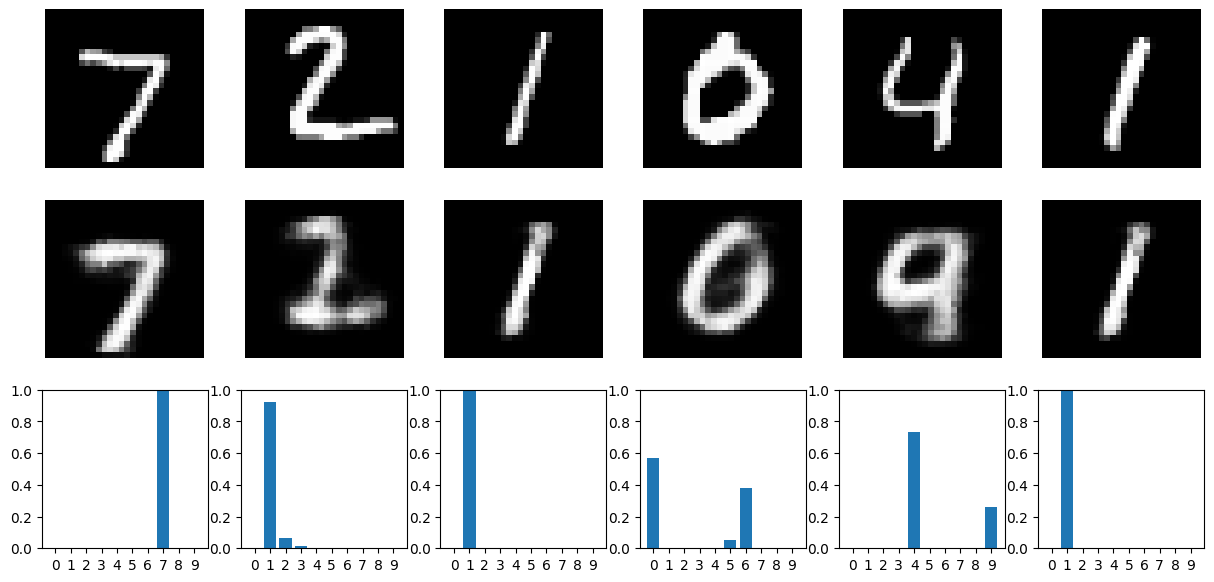

In [6]:
import matplotlib.pyplot as plt

# Select a few test examples
num_examples = 6
x_test_subset = x_test[:num_examples]

# Get the model's predictions for the test examples
decoded_imgs, mlp_preds = model.predict(x_test_subset)

# Plot the input images, reconstructed images, and MLP predictions
fig, axes = plt.subplots(nrows=3, ncols=num_examples, figsize=(num_examples*2.5, 7))

for i in range(num_examples):
    # Plot the input image
    axes[0][i].imshow(x_test_subset[i].reshape(28, 28), cmap='gray')
    axes[0][i].axis('off')
    
    # Plot the reconstructed image
    axes[1][i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1][i].axis('off')
    
    # Plot the MLP predictions
    axes[2][i].bar(range(10), mlp_preds[i])
    axes[2][i].set_xticks(range(10))
    axes[2][i].set_ylim([0, 1])
    
plt.show()
